In [1]:
"""
Iterative Closest Point (ICP) SLAM example
author: Atsushi Sakai (@Atsushi_twi)
https://github.com/AtsushiSakai/PythonRobotics
"""

import math
import numpy as np
import matplotlib.pyplot as plt

In [13]:
import sys
sys.path.insert(0, 'code')
from robot_data import Load_Lidar_Scans as load_scans
%matplotlib inline
scans_OBJ = load_scans()
scans_OBJ.load_ranges('data\\LidarScans_ranges.txt')
scans_OBJ.load_angles('data\\LidarScans_angles.txt')
import coordinate_transforms as cord_trans
read = np.transpose(cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[1]))
reference = np.transpose(cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0]))

In [9]:
#  ICP parameters
EPS = 0.0001
MAXITER = 100

In [17]:
def v2t(vector):
    return np.vstack((vector,1))

In [4]:
def ICP_matching(ppoints, cpoints):
    H = []

    dError = 1000.0
    preError = 1000.0
    count = 0

    while dError >= EPS:
        count += 1

        inds, error = nearest_neighbor_assosiation(ppoints, cpoints)
        Rt, Tt = SVD_motion_estimation(ppoints[:, inds], cpoints)

        # update current points
        #cpoints = (Rt * cpoints) + Tt
        cpoints = (H * cpoints)

        H = update_homogenerous_matrix(H, Rt, Tt)

        dError = abs(preError - error)
        preError = error
        print("Residual:", error)

        if dError <= EPS:
            print("Converge", error, dError, count)
            break
        elif MAXITER <= count:
            print("Not Converge...", error, dError, count)
            break

    R = np.matrix(H[0:2, 0:2])
    T = np.matrix(H[0:2, 2])

    return R, T

In [5]:
def update_homogenerous_matrix(Hin, R, T):

    H = np.matrix(np.zeros((3, 3)))

    H[0, 0] = R[0, 0]
    H[1, 0] = R[1, 0]
    H[0, 1] = R[0, 1]
    H[1, 1] = R[1, 1]
    H[2, 2] = 1.0

    H[0, 2] = T[0, 0]
    H[1, 2] = T[1, 0]

    if Hin is None:
        return H
    else:
        return Hin * H

In [6]:
def nearest_neighbor_assosiation(ppoints, cpoints):

    # calc the sum of residual errors
    dcpoints = ppoints - cpoints
    d = np.linalg.norm(dcpoints, axis=0)
    error = sum(d)

    # calc index with nearest neighbor assosiation
    inds = []
    for i in range(cpoints.shape[1]):
        minid = -1
        mind = float("inf")
        for ii in range(ppoints.shape[1]):
            d = np.linalg.norm(ppoints[:, ii] - cpoints[:, i])

            if mind >= d:
                mind = d
                minid = ii

        inds.append(minid)

    return inds, error

In [16]:
def SVD_motion_estimation(ppoints, cpoints):

    pm = np.matrix(np.mean(ppoints, axis=1))
    cm = np.matrix(np.mean(cpoints, axis=1))
    
    pshift = np.matrix(ppoints - pm)
    cshift = np.matrix(cpoints - cm)

    W = cshift * pshift.T
    u, s, vh = np.linalg.svd(W)

    R = (u * vh).T
    t = pm - R * cm
    
    return R, t

 start!!
Residual: 132.391310002
Residual: 142.083978402
Residual: 148.948510554
Residual: 153.6573736
Residual: 156.226480117
Residual: 157.339832921
Residual: 158.07598918
Residual: 158.877986222
Residual: 159.512433428
Residual: 159.858263672
Residual: 160.155593823
Residual: 160.468804876
Residual: 160.579619305
Residual: 160.720525279
Residual: 160.744883581
Residual: 160.770336433
Residual: 160.850847103
Residual: 160.885781404
Residual: 160.942718356
Residual: 160.941766892
Residual: 160.94166641
Residual: 160.941655794
Converge 160.941655794 1.06157772848e-05 22


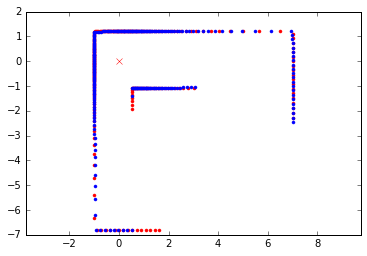

In [15]:
print(" start!!")

# simulation parameters
nPoint = 10
fieldLength = 50.0
#motion = [0.5, 2.0, np.deg2rad(-10.0)]  # movement [x[m],y[m],yaw[deg]]

nsim = 1  # number of simulation

for _ in range(nsim):

    # previous points
#    px = (np.random.rand(nPoint) - 0.5) * fieldLength
#    py = (np.random.rand(nPoint) - 0.5) * fieldLength
#    ppoints = np.matrix(np.vstack((px, py)))
    ppoints = np.matrix(np.vstack((reference[0,:], reference[1,:])))

    # current points
#    cx = [math.cos(motion[2]) * x - math.sin(motion[2]) * y + motion[0]
#          for (x, y) in zip(px, py)]
#    cy = [math.sin(motion[2]) * x + math.cos(motion[2]) * y + motion[1]
#          for (x, y) in zip(px, py)]
#    cpoints = np.matrix(np.vstack((cx, cy)))
    cpoints = np.matrix(np.vstack((read[0,:], read[1,:])))

    R, T = ICP_matching(ppoints, cpoints)

#print('\n')    
#print(np.transpose(T),np.arccos(R[0,0]))
#print([0.48333001, 0, 0.0],'\n')